In [1]:
from src.PreProcess import getDegreeSequences
import networkx as nx
import pandas as pd
from src.struc2vec import struc2vec
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# from src.GraphAlgorithms import GraphAlgorithms as ga

In [3]:
df = pd.read_excel("src/UN_full.xlsx")

In [4]:
edgelist = [(origin, destination, {"weight":weight}) for origin, destination, weight in df[["origin","destination","weight_scaled"]].values]

In [5]:
G_D = nx.DiGraph(edgelist)
# G_UD = nx.Graph(edgelist)

In [6]:
# Let's start by getting the adjacency matrix
A = nx.adjacency_matrix(G_D).toarray()

In [7]:
for i in range(len(A)):
    A[i,:] /= A[i,:].sum()

In [8]:
# For convenience, let's make it into a pandas dataframe
df = pd.DataFrame(A).stack().reset_index()
df.columns = ("source", "target", "weight")
df = df[df["weight"] > 0]

In [9]:
indexNodes = {i: node for i, node in enumerate(G_D.nodes())}

In [10]:
quat25 = df["weight"].describe()["25%"]
quat50 = df["weight"].describe()["50%"]
quat75 = df["weight"].describe()["75%"]

print(quat25,quat50,quat75)

0.000171368592421224 0.0013355643910900972 0.009280984410031808


In [11]:
removeEdgesDict = {}
for (perc, lim) in [("25",quat25), ("50", quat50), ("75",quat75)]:
    removeEdges = [(indexNodes[int(origin)], indexNodes[int(destination)]) for [origin, destination, weight] in df[df["weight"]<lim].values]
    removeEdgesDict[perc] = removeEdges

In [12]:
for perc, list in removeEdgesDict.items():
    print(perc, len(list))

25 2074
50 4148
75 6222


In [13]:
G_D25 = G_D.copy()
G_D50 = G_D.copy()
G_D75 = G_D.copy()

In [14]:
for (perc, graph) in [("25",G_D25), ("50", G_D50), ("75", G_D75)]:
    edges = removeEdgesDict[perc]
    for (origin, destination) in edges:
        graph.remove_edge(origin, destination)

In [15]:
weights = np.array([edge[2]["weight"] for edge in G_D75.edges(data=True)])

In [58]:
def scale_x(x):
    min_weight = np.min(weights)
    max_weight = np.max(weights)
    min_scale = 0.1
    max_scale = 10
    return (((max_scale-min_scale)*(x-min_weight))/(max_weight-min_weight))+min_scale

In [17]:
weights_scaled = [scale_x(w) for w in weights]

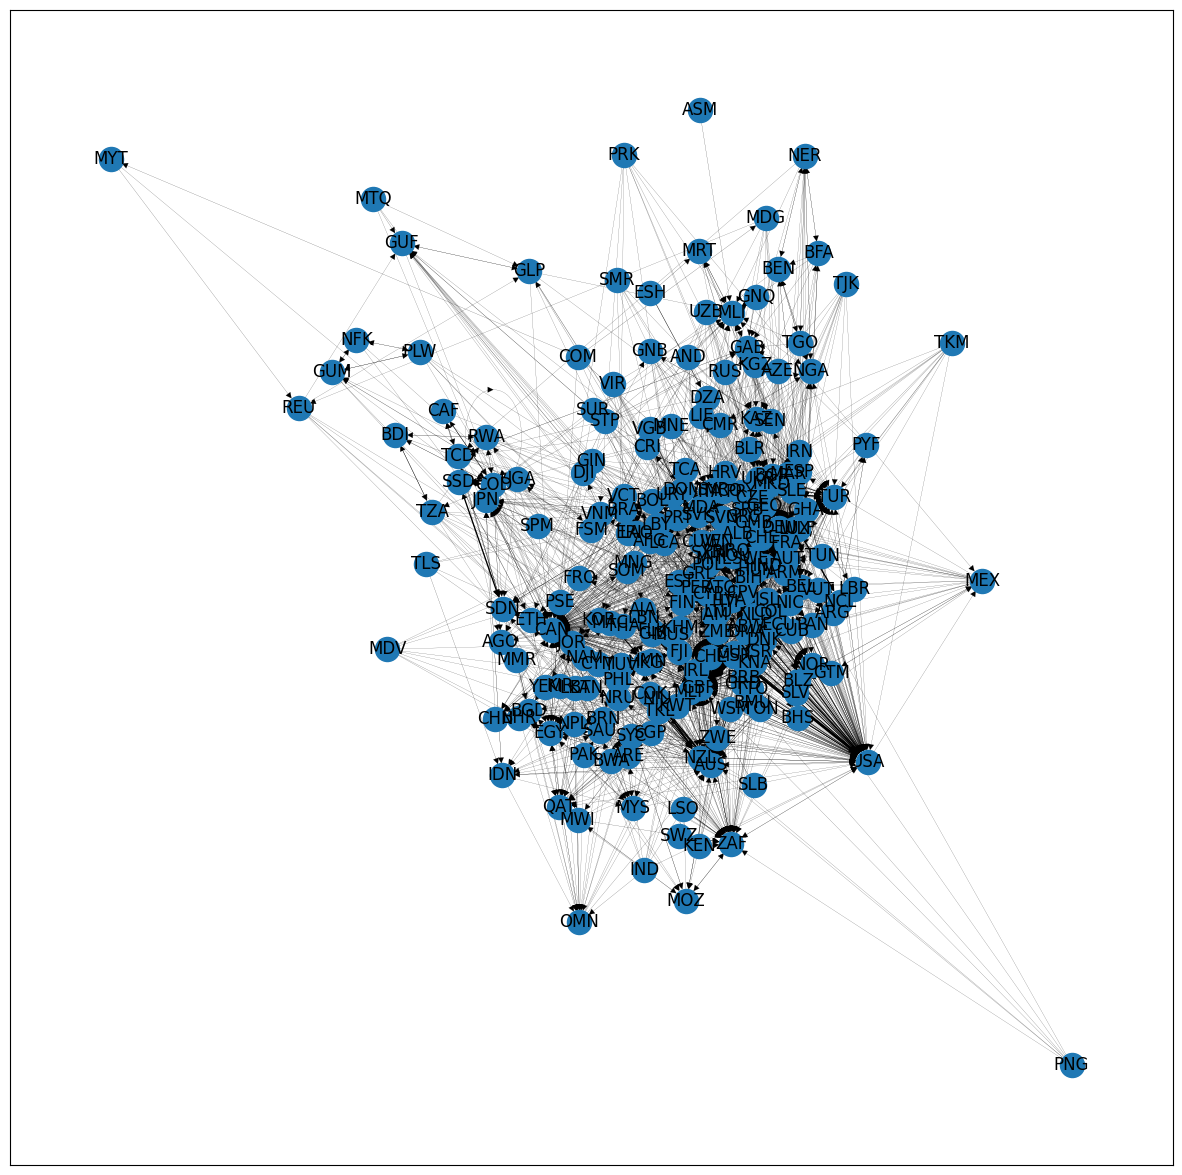

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))

# nx.draw_networkx(G_D75, width=weights_scaled)

In [18]:
G_UD25 = nx.Graph(G_D25)
G_UD50 = nx.Graph(G_D50)
G_UD75 = nx.Graph(G_D75)

In [53]:
s2vG = struc2vec(G_D)
s2vG25 = struc2vec(G_D25)
s2vG50 = struc2vec(G_D50)
s2vG75 = struc2vec(G_D75)

In [21]:
for (perc, cur_s2vG) in [("25", s2vG25), ("50", s2vG50), ("75", s2vG75)]:
    cur_s2vG.getMultiLevelGraph(path=f"GML/{perc}")
    # for i, G in cur_s2vG.G_ML.items():
    #     nx.write_gexf(G, f"GML/{perc}/{i}.gexf")


In [23]:
walks = []
for s2vG in [s2vG25,s2vG50,s2vG75]:
    walks_ = s2vG.getRandomWalks(number_of_walks = 1000, walk_length=40)
    walks.extend(walks_)

In [37]:
walks = s2vG25.getRandomWalks(number_of_walks = 1000, walk_length=40)

In [38]:
model = Word2Vec(walks, vector_size=75)

In [39]:
embeddings = {node: model.wv[node] for node in s2vG25.nodes}

In [ ]:
emb_v = [x for x in embeddings.values()]
X = np.array(emb_v)

In [45]:
pca = PCA(n_components=10)
pca.fit(X)

PCA(n_components=10)

In [46]:
eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

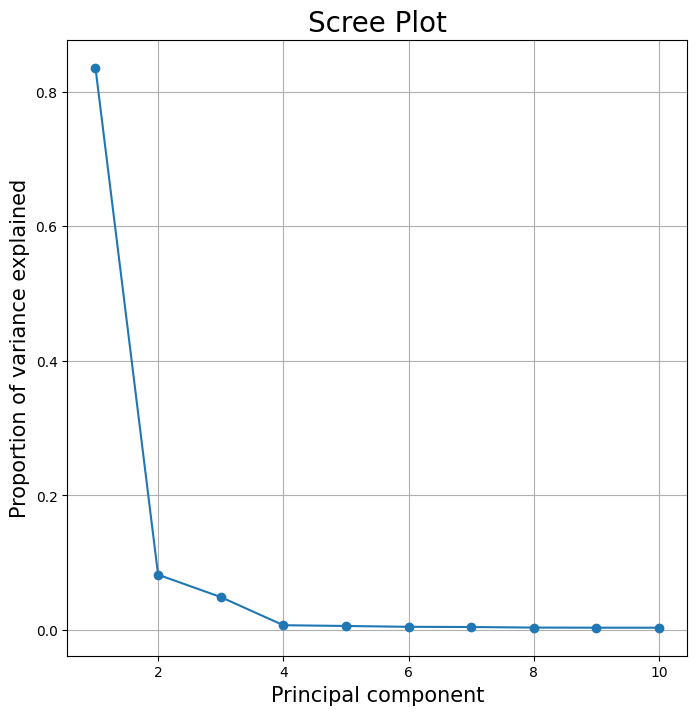

In [47]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal component',
           size = 15)
plt.ylabel('Proportion of variance explained',
           size = 15)
plt.title('Scree Plot',
          size = 20)
plt.grid(True)

# plt.savefig("Visualisations/scree_plot.jpg")

In [48]:
pca = PCA(n_components=4)
X_transform = pca.fit_transform(X)

In [50]:
node_embeddings = {}
for node, embedding in enumerate(X_transform):
    emb_list = [x for x in embedding]
    index = emb_list.index(max(emb_list))
    node_embeddings[node] = index

In [52]:
cmap = {0:"lightblue",1:"lightyellow", 2:"orange",3:"pink", 4:"purple", 5:"red", 6:"lightgrey"}
nodecolors = [cmap[v] for k,v in node_embeddings.items()]

In [59]:
weights = [edge[2]["weight"] for edge in s2vG.G_D.edges(data=True)]
weights_scaled = [scale_x(w) for w in weights]

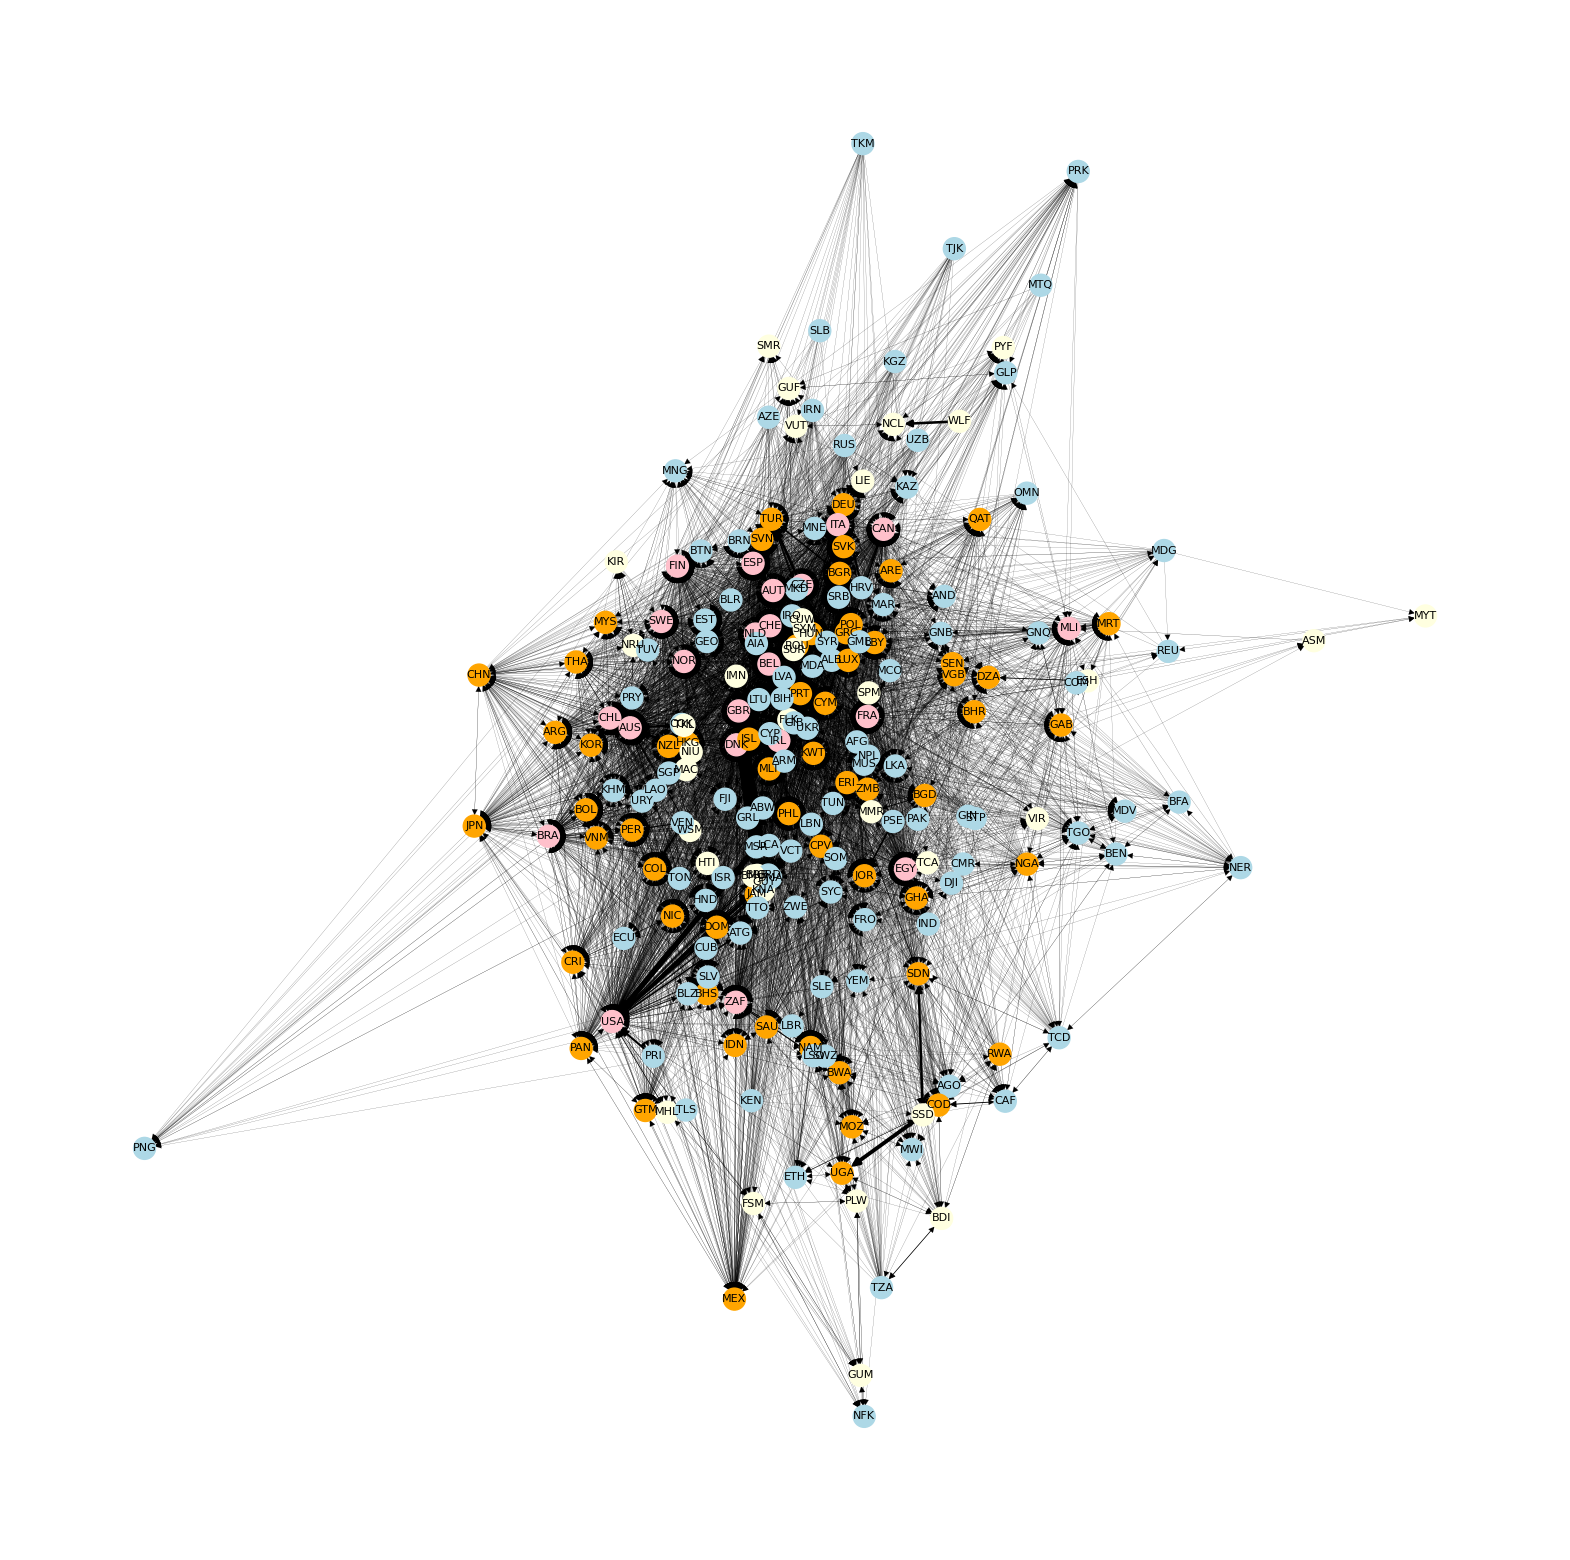

In [60]:
fig, ax = plt.subplots(figsize=(20,20))

nx.draw_spring(s2vG.G_D, with_labels=True, node_color=nodecolors, width = weights_scaled, node_size=250, font_size=8)

In [68]:
df_meta = pd.DataFrame([(node, embedding) for node,embedding in zip(embeddings.keys(),node_embeddings.values())], columns=["Node", "Embedding"])

### Clustering

In [70]:
clustering = nx.clustering(s2vG.G_D)

In [71]:
df_meta["Clustering"] = [clustering[node] for node in df_meta["Node"]]

In [72]:
df_meta.groupby("Embedding")["Clustering"].mean()

Embedding
0    0.696581
1    0.653569
2    0.546925
3    0.319753
Name: Clustering, dtype: float64

### Centrality

In [73]:
between = nx.betweenness_centrality(s2vG.G_D)
df_meta["Betweenness_centrality"] = [between[node] for node in df_meta["Node"]]

In [74]:
df_meta.groupby("Embedding")["Betweenness_centrality"].mean()

Embedding
0    0.000538
1    0.000329
2    0.003138
3    0.025692
Name: Betweenness_centrality, dtype: float64

In [75]:
closeness = nx.closeness_centrality(s2vG.G_D)
df_meta["Closeness_centrality"] = [closeness[node] for node in df_meta["Node"]]

In [76]:
df_meta.groupby("Embedding")["Closeness_centrality"].mean()

Embedding
0    0.322975
1    0.431749
2    0.555351
3    0.789608
Name: Closeness_centrality, dtype: float64

### Degrees

In [98]:
A = nx.adjacency_matrix(s2vG.G_D, weight=None) # All cells are either 0 or 1 to support counting for degree
ind2node = {i:node for i, node in enumerate(s2vG.G_D.nodes())}

# 1
# From the adj matrix, the in and out degree can be calculated as a sum of each row
# and corresponding column
degreeDict = {}
for i in range(A.shape[0]):
    inDegree = A[:,[i]].sum()
    outDegree = A[[i],:].sum()
    degreeDict[ind2node[i]] = {"inDegree":inDegree, "outDegree":outDegree}

In [99]:
df_meta["InDegree"] = [degreeDict[node]["inDegree"] for node in df_meta["Node"]]
df_meta["OutDegree"] = [degreeDict[node]["outDegree"] for node in df_meta["Node"]]

In [100]:
df_meta.groupby("Embedding")["InDegree"].mean()

Embedding
0     10.481481
1     10.371429
2     52.885246
3    162.545455
Name: InDegree, dtype: float64

In [101]:
df_meta.groupby("Embedding")["OutDegree"].mean()

Embedding
0    32.518519
1    11.228571
2    46.786885
3    69.909091
Name: OutDegree, dtype: float64

In [80]:
avg_weight = {}
for node in G_D.nodes():
    data = G_D[node]
    weights = []
    for dest, data in data.items():
        weights.append(data["weight"])
    avg_weight[node] = np.mean(weights)

In [81]:
df_meta["Average_weight"] = [avg_weight[node] for node in df_meta["Node"]]

In [82]:
df_meta.groupby("Embedding")["Average_weight"].mean()

Embedding
0    10.362070
1    47.184787
2     1.950188
3     0.626936
Name: Average_weight, dtype: float64

In [105]:
df_grouped = pd.DataFrame(df_meta.groupby("Embedding")["Node"].count())
df_grouped.columns = ["Number of nodes"]

In [106]:
df_grouped["Color"] = [cmap[emb] for emb in df_grouped.index]

In [107]:
avg_data = df_meta.drop("Node",axis=1).groupby("Embedding").mean().apply(lambda x: round(x, 3))

In [108]:
df_grouped = df_grouped.merge(avg_data, right_index=True, left_index=True)

In [109]:
df_grouped

,Number of nodes,Color,Clustering,Betweenness_centrality,Closeness_centrality,Degree,Average_weight,InDegree,OutDegree
Embedding,,,,,,,,,
0,108,lightblue,0.697,0.001,0.323,43.000,10.362,10.481,32.519
1,35,lightyellow,0.654,0.000,0.432,21.600,47.185,10.371,11.229
2,61,orange,0.547,0.003,0.555,99.672,1.950,52.885,46.787
3,22,pink,0.320,0.026,0.790,232.455,0.627,162.545,69.909
